Projeto de Inteligência Artifical voltado para o Reconhecimento da Datilologia

Grupo: Alina Tainá Germano Costa, Júlia de Oliveira Tavares, Lucas Emanuel Camilo Bezerra e Pedro Henrique Correia Bezerra Silva

A FAZER:
- CRIAR GRÁFICOS: MUITO IMPORTANTE PARA ENTENDER OS RESULTADOS DOS MODELOS
- DIVIDIR A PARTE DE VALIDAÇÃO
- USAR A BIBLIOTECA GRIDSEARCHCV
- RESPONDER O RELATÓRIO COM BASE NOS RESULTADOS OBTIDOS 
- APRESENTAR COM FUNDAMENTO SOBRE O PORQUÊ DAS NOSSAS ESCOLHAS

POSSIBILIDADE: 
- ALGORITMOS DE OTIMIZAÇÃO JUNTO DO GRIDSEARCHCV
- IDENTIFICAR O SINAL PELA WEBCAM AO VIVO

In [60]:
# import de algumas bibliotecas essenciais: PIL, Image - faz o processo de conversão da imagem; Numpy - fundamental para a manipulação de dados; 
# Matplotlib.pyplot - essencial para a plotagem de gráficos; os - necessária para acessar as imagens dentro do diretório "datilologia"
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import os

In [65]:
# Carregar os dados preparados
x_treino = np.load('x_treino.npy')  # Carrega as imagens de treinamento
y_treino = np.load('y_treino.npy')  # Carrega os rótulos de treinamento
z_treino = np.load('z_treino.npy')

x_validacao = np.load('x_validacao.npy')  # Carrega as imagens de validação
y_validacao = np.load('y_validacao.npy')  # Carrega os rótulos de validação
z_validacao = np.load('z_validacao.npy')

x_teste = np.load('x_teste.npy')  # Carrega as imagens de teste
y_teste = np.load('y_teste.npy')  # Carrega os rótulos de teste
z_teste = np.load('z_teste.npy')

print(np.shape(x_treino))
print(np.shape(x_validacao))
print(np.shape(x_teste))

(27771, 4096)
(6943, 4096)
(11548, 4096)


In [33]:
def plotar_matriz_confusao(respostas, predicoes, rotulos):
    cm = confusion_matrix(respostas, predicoes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rotulos, yticklabels=rotulos)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def plotar_relatorio_classificacao(respostas, predicoes, rotulos):
    report = classification_report(respostas, predicoes, target_names=rotulos, output_dict=True)
    metrics = ['precision', 'recall', 'f1-score']
    data = {metric: [report[cls][metric] for cls in rotulos] for metric in metrics}
    x = np.arange(len(rotulos))

    plt.figure(figsize=(10, 6))
    for i, metric in enumerate(metrics):
        plt.bar(x + i * 0.2, data[metric], width=0.2, label=metric)

    plt.xticks(x + 0.2, rotulos)
    plt.ylabel('Scores')
    plt.title('Classification Metrics by Class')
    plt.legend()
    plt.show()

def plotar_curvas_roc(respostas, probabilidade, rotulos):
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(rotulos):
        fpr, tpr, _ = roc_curve(respostas == i, probabilidade[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

In [34]:
# Definir o PCA para reter 95% da variância dos dados
pca = PCA(n_components=0.95)  # Retém 95% da variância
x_treino_pca = pca.fit_transform(x_treino)
x_validacao_pca = pca.transform(x_validacao)
x_teste_pca = pca.transform(x_teste)

print("TREINAMENTO")
print(f"Dimensões originais: {np.shape(x_treino)}")
print(f"Dimensões após PCA: {np.shape(x_treino_pca)}")
print("VALIDAÇÃO")
print(f"Dimensões originais: {np.shape(x_validacao)}")
print(f"Dimensões após PCA: {np.shape(x_validacao_pca)}")
print("TESTE")
print(f"Dimensões originais: {np.shape(x_teste)}")
print(f"Dimensões após PCA: {np.shape(x_teste_pca)}")

TREINAMENTO
Dimensões originais: (27771, 4096)
Dimensões após PCA: (27771, 228)
VALIDAÇÃO
Dimensões originais: (6943, 4096)
Dimensões após PCA: (6943, 228)
TESTE
Dimensões originais: (11548, 4096)
Dimensões após PCA: (11548, 228)


In [35]:
# ESSE PROCESSO JÁ TÁ SENDO FEITO NO INDEX
# Entender o formato 'shape' do array
# data_shape = np.shape(x_treino)
# print(data_shape)


# Realizar a reformatação do array para que consiga entrar no modelo KNN ('reshape')
# x_treino = np.reshape(x_treino, (data_shape[0], data_shape[1] * data_shape[2]))
# print(np.shape(x_treino))

# x_validacao = np.reshape(x_validacao, (data_shape[0], data_shape[1] * data_shape[2]))
# print(np.shape(x_validacao))

# x_teste = np.reshape(x_teste, (data_shape[0], data_shape[1] * data_shape[2]))
# print(np.shape(x_teste))

# KNN com os dados padrão
- n_neighbors: 5
- weights: 'uniform'
- algorithm: 'auto'
- leaf_size: 30
- p: 2
- metric: 'minkowski'
- metric_params: None
- n_jobs: None

In [68]:
knn_padrao = KNeighborsClassifier()

knn_padrao.fit(x_treino_pca, z_treino)

predicao_validacao_padrao = knn_padrao.predict(x_validacao_pca)
treino_acuracia_padrao = accuracy_score(z_validacao, predicao_validacao_padrao)

mae_validacao_padrao = mean_absolute_error(z_validacao, predicao_validacao_padrao)
rmse_validacao_padrao = root_mean_squared_error(z_validacao, predicao_validacao_padrao)

print("Acurácia:", treino_acuracia_padrao)
print("MAE:", mae_validacao_padrao)
print("RMSE:", rmse_validacao_padrao)

Acurácia: 0.001152239665850497
MAE: 16.19328820394642
RMSE: 17.278805163507073


In [69]:
knn_padrao = KNeighborsClassifier()

knn_padrao.fit(x_treino_pca, y_treino)

KNeighborsClassifier()

In [70]:
predicao_validacao_padrao = knn_padrao.predict(x_validacao_pca)
treino_acuracia_padrao = accuracy_score(y_validacao, predicao_validacao_padrao)

print("Acurácia:", treino_acuracia_padrao)
print("Relatório de Classificação (modelo inicial):\n", classification_report(y_validacao, predicao_validacao_padrao))

Acurácia: 0.9936626818378222


In [ ]:
predicao_teste_padrao = knn_padrao.predict(x_teste_pca)
teste_acuracia_padrao = accuracy_score(y_teste, predicao_teste_padrao)  

print("Acurácia:", teste_acuracia_padrao)
print("Relatório de Classificação (modelo inicial):\n", classification_report(y_validacao, predicao_teste_padrao))

Acurácia: 0.9132317284378247


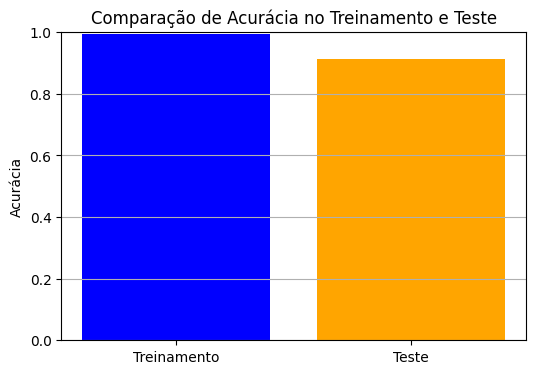

Relatório de Classificação no Teste:
              precision    recall  f1-score   support

           A       0.84      0.91      0.87       579
           B       0.87      0.99      0.93       562
           C       0.98      0.93      0.95       583
           D       0.80      0.94      0.86       550
           E       0.88      0.81      0.84       574
           F       0.93      0.94      0.93       450
           G       0.95      0.86      0.90       550
           I       0.86      0.94      0.90       550
           L       0.92      0.94      0.93       550
           M       0.89      0.96      0.92       550
           N       0.96      0.86      0.91       550
           O       0.97      0.91      0.94       550
           P       0.99      1.00      1.00       550
           Q       0.94      0.97      0.95       550
           R       0.82      0.77      0.79       550
           S       0.91      0.81      0.86       550
           T       0.91      0.93      0.92 

In [40]:
# Visualização dos resultados
plt.figure(figsize=(6, 4))
plt.bar(['Treinamento', 'Teste'], [treino_acuracia_padrao, teste_acuracia_padrao], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia no Treinamento e Teste')
plt.grid(axis='y')
plt.show()

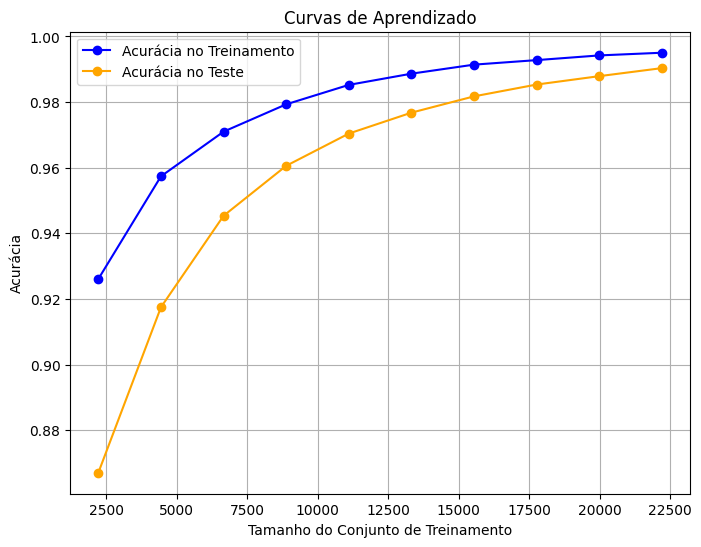

In [41]:
train_sizes, train_scores, test_scores = learning_curve(
    knn_padrao, x_treino_pca, y_treino, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Acurácia no Treinamento', marker='o', color='blue')
plt.plot(train_sizes, test_mean, label='Acurácia no Teste', marker='o', color='orange')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.title('Curvas de Aprendizado')
plt.legend()
plt.grid()
plt.show()


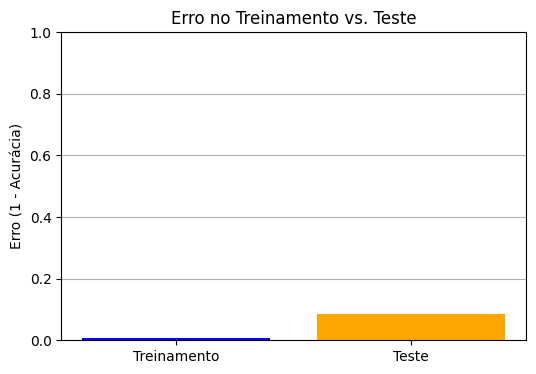

In [42]:
train_error = 1 - treino_acuracia_padrao
test_error = 1 - teste_acuracia_padrao

plt.figure(figsize=(6, 4))
plt.bar(['Treinamento', 'Teste'], [train_error, test_error], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Erro (1 - Acurácia)')
plt.title('Erro no Treinamento vs. Teste')
plt.grid(axis='y')
plt.show()


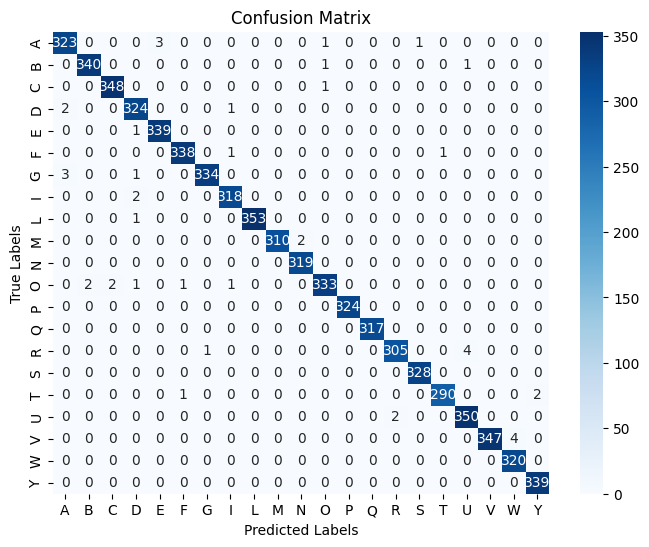

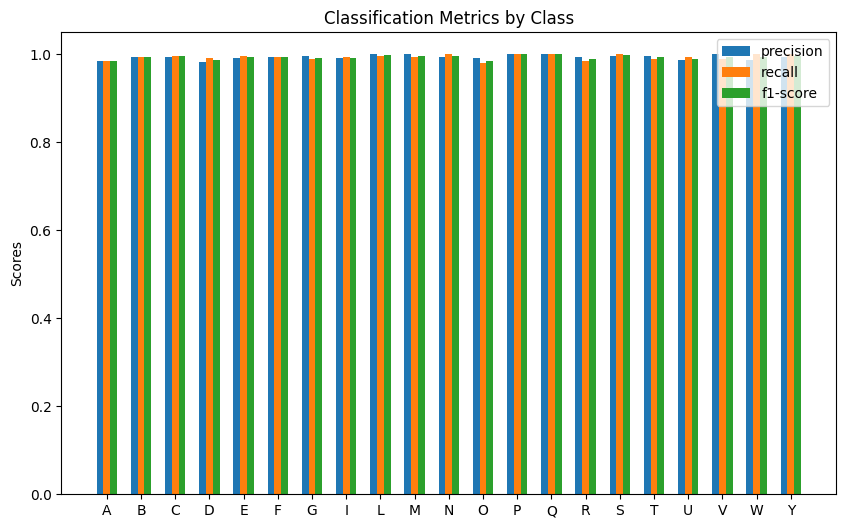

c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: Undefined

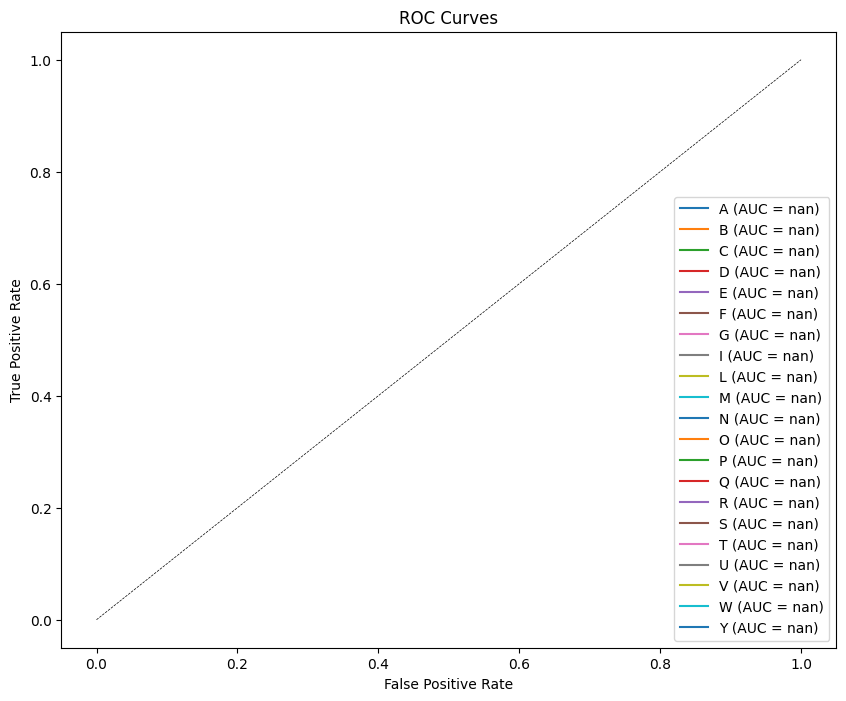

In [43]:
# Código para gerar gráficos de métricas do modelo.
letras = ["A", "B", "C", "D", "E", "F", "G", "I", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "Y"]
y_prob_validacao = knn_padrao.predict_proba(x_validacao_pca)

# Código de exemplo (ajustar conforme as variáveis do notebook)
plotar_matriz_confusao(y_validacao, predicao_validacao_padrao, letras)
plotar_relatorio_classificacao(y_validacao, predicao_validacao_padrao, letras)
plotar_curvas_roc(y_validacao, y_prob_validacao, letras)

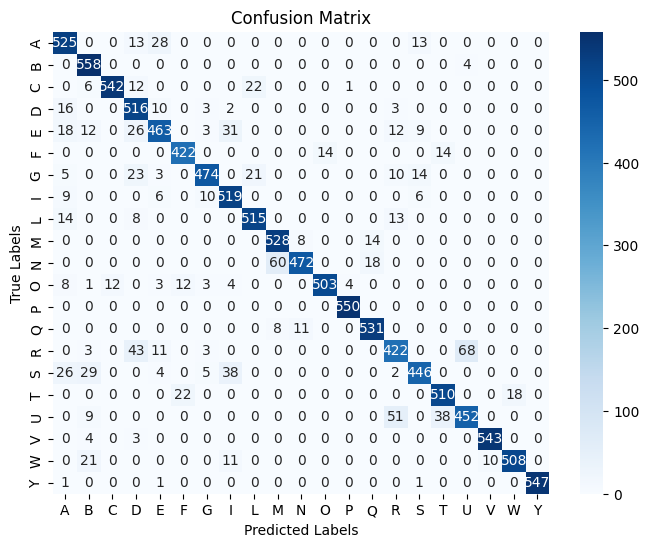

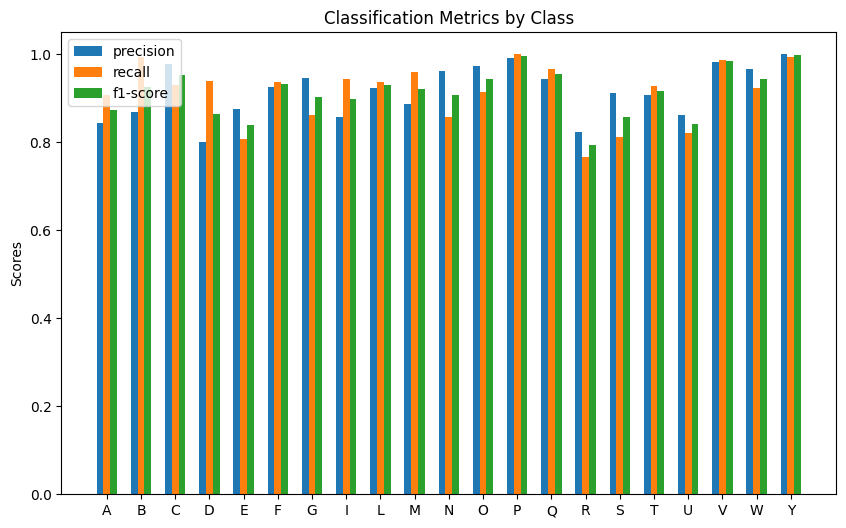

c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: Undefined

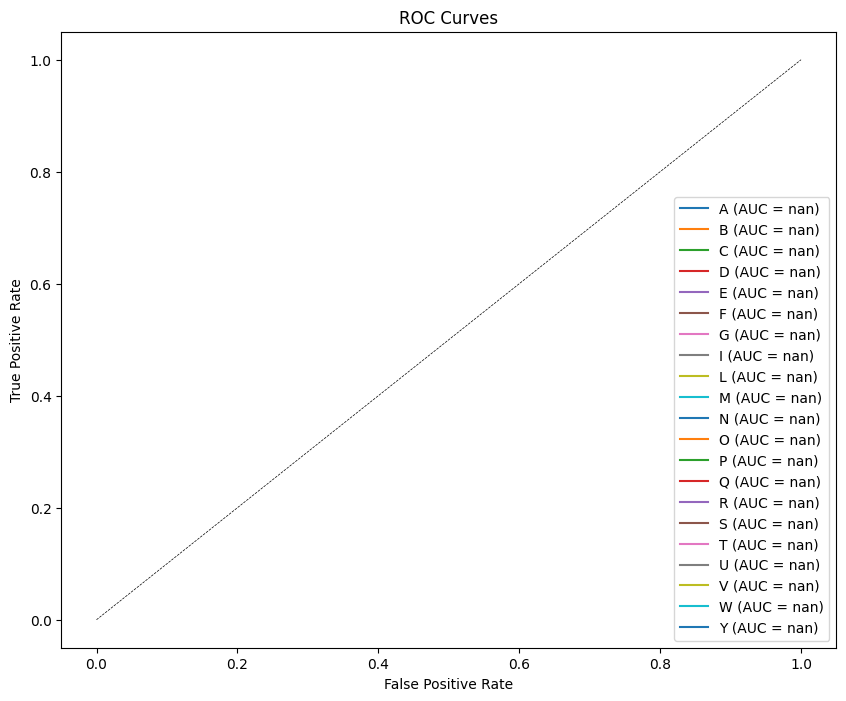

In [44]:
# Código para gerar gráficos de métricas do modelo.
letras = ["A", "B", "C", "D", "E", "F", "G", "I", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "Y"]
y_prob_teste = knn_padrao.predict_proba(x_teste_pca)

# Código de exemplo (ajustar conforme as variáveis do notebook)
plotar_matriz_confusao(y_teste, predicao_teste_padrao, letras)
plotar_relatorio_classificacao(y_teste, predicao_teste_padrao, letras)
plotar_curvas_roc(y_teste, y_prob_teste, letras)

In [ ]:
x_validacao_ruidosa = x_validacao_pca + np.random.normal(0, 0.1, x_validacao_pca.shape)
x_validacao_ruidosa = np.clip(x_validacao_ruidosa, 0, 1)

y_pred_ruidosa = knn_padrao.predict(x_validacao_ruidosa)
treino_acuracia_padrao = accuracy_score(y_validacao, y_pred_ruidosa)

print("Acurácia:", treino_acuracia_padrao)

In [ ]:
knn_padrao = KNeighborsClassifier()

knn_padrao.fit(x_treino_pca, y_treino)

x_teste_ruidosa = x_teste_pca + np.random.normal(0, 0.1, x_teste_pca.shape)
x_teste_ruidosa = np.clip(x_teste_ruidosa, 0, 1)

y_pred_ruidosa = knn_padrao.predict(x_teste_ruidosa)
teste_acuracia_padrao = accuracy_score(y_teste, y_pred_ruidosa)

print("Acurácia:", teste_acuracia_padrao)

# KNN com GridSearchCV
- n_neighbors: 3
- metric: 'euclidean'

In [76]:
# GRIDSEARCHCV com PCA

# Modelo e hiperparâmetros
knn_grid = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 9, 15],
    'metric': ['euclidean', 'manhattan', 'minkowski']  
}

# Busca de hiperparâmetros com validação cruzada
grid_search = GridSearchCV(estimator=knn_grid, param_grid=param_grid, cv=2, scoring='accuracy', verbose=1)
grid_search.fit(x_treino_pca, y_treino)


Fitting 2 folds for each of 12 candidates, totalling 24 fits


c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
 

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 9, 15]},
             scoring='accuracy', verbose=1)

In [77]:
# Melhores parâmetros
print("Melhores Parâmetros:", grid_search.best_params_)
print("Melhor Acurácia na Validação Cruzada:", grid_search.best_score_)

Melhores Parâmetros: {'metric': 'euclidean', 'n_neighbors': 3}
Melhor Acurácia na Validação Cruzada: 0.9876130112629146


In [78]:
# Modelo com os melhores hiperparâmetros
knn_otimizado = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], metric=grid_search.best_params_['metric'])
knn_otimizado.fit(x_treino_pca, y_treino)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [79]:
# Acurácia no conjunto de treinamento
predicao_validacao_otimizado = knn_otimizado.predict(x_validacao_pca)
validacao_acuracia_otimizado = accuracy_score(y_validacao, predicao_validacao_otimizado)
print("Acurácia no Treinamento:", validacao_acuracia_otimizado)

print("Acurácia:", validacao_acuracia_otimizado)

Acurácia no Treinamento: 0.9963992510442172
Acurácia: 0.9963992510442172


In [80]:
# Acurácia no conjunto de teste
predicao_teste_otimizado = knn_otimizado.predict(x_teste_pca)
teste_acuracia_otimizado = accuracy_score(y_teste, predicao_teste_otimizado)

print("Acurácia:", teste_acuracia_otimizado)

Acurácia: 0.9167821267751992


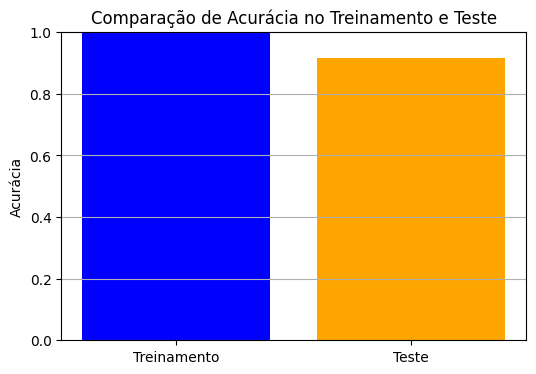

Relatório de Classificação no Teste:
              precision    recall  f1-score   support

           A       0.87      0.91      0.89       579
           B       0.87      0.98      0.92       562
           C       0.98      0.93      0.95       583
           D       0.80      0.98      0.88       550
           E       0.90      0.81      0.85       574
           F       0.88      0.94      0.91       450
           G       0.94      0.87      0.91       550
           I       0.89      0.97      0.93       550
           L       0.93      0.93      0.93       550
           M       0.89      0.97      0.93       550
           N       0.95      0.85      0.90       550
           O       0.97      0.91      0.94       550
           P       0.99      1.00      0.99       550
           Q       0.94      0.97      0.96       550
           R       0.82      0.78      0.80       550
           S       0.92      0.82      0.86       550
           T       0.90      0.89      0.89 

In [81]:
# Visualização dos resultados
plt.figure(figsize=(6, 4))
plt.bar(['Treinamento', 'Teste'], [validacao_acuracia_otimizado, teste_acuracia_otimizado], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia no Treinamento e Teste')
plt.grid(axis='y')
plt.show()

# Detalhes adicionais
print("Relatório de Classificação no Teste:")
print(classification_report(y_teste, predicao_teste_otimizado))

print("Matriz de Confusão no Teste:")
print(confusion_matrix(y_teste, predicao_teste_otimizado))

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    knn_otimizado, x_treino_pca, y_treino, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Acurácia no Treinamento', marker='o', color='blue')
plt.plot(train_sizes, test_mean, label='Acurácia no Teste', marker='o', color='orange')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.title('Curvas de Aprendizado')
plt.legend()
plt.grid()
plt.show()


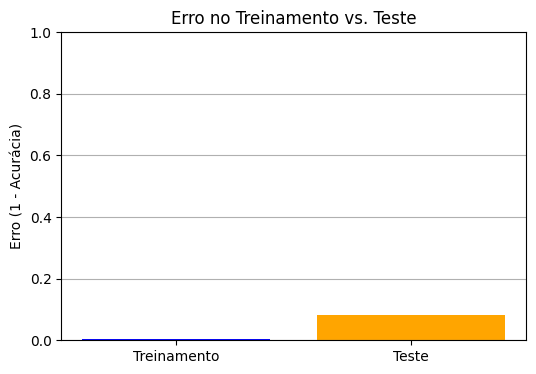

In [57]:
train_error = 1 - validacao_acuracia_otimizado
test_error = 1 - teste_acuracia_otimizado

plt.figure(figsize=(6, 4))
plt.bar(['Treinamento', 'Teste'], [train_error, test_error], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Erro (1 - Acurácia)')
plt.title('Erro no Treinamento vs. Teste')
plt.grid(axis='y')
plt.show()


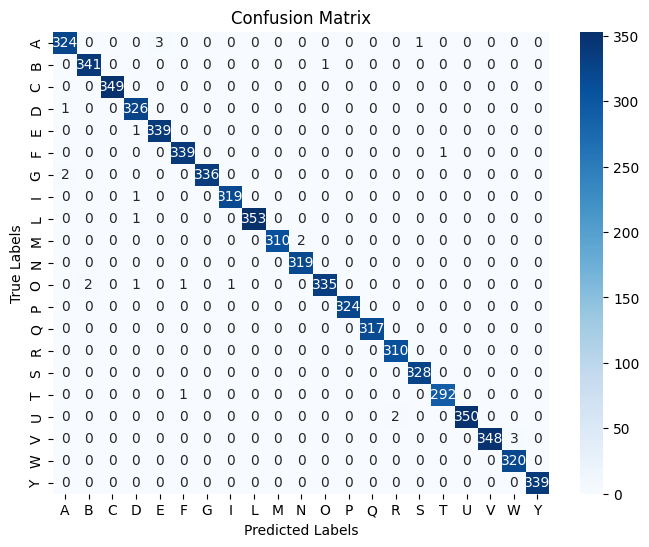

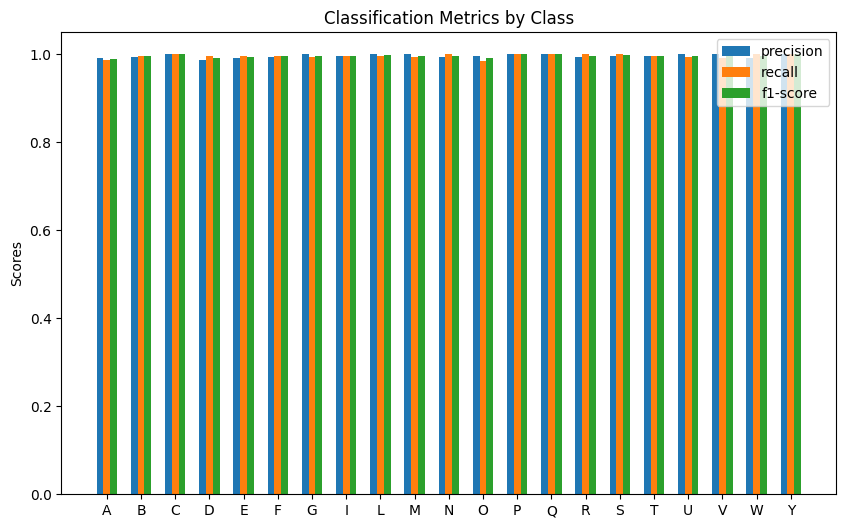

c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: Undefined

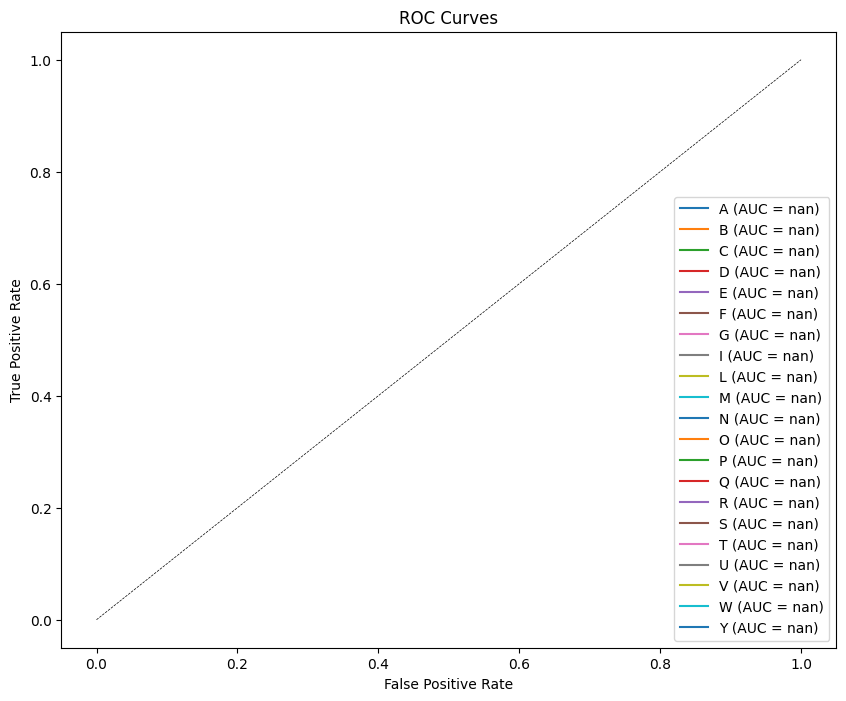

In [58]:
# Código para gerar gráficos de métricas do modelo.
letras = ["A", "B", "C", "D", "E", "F", "G", "I", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "Y"]
y_prob_validacao = knn_otimizado.predict_proba(x_validacao_pca)

# Código de exemplo (ajustar conforme as variáveis do notebook)
plotar_matriz_confusao(y_validacao, predicao_validacao_otimizado, letras)
plotar_relatorio_classificacao(y_validacao, predicao_validacao_otimizado, letras)
plotar_curvas_roc(y_validacao, y_prob_validacao, letras)

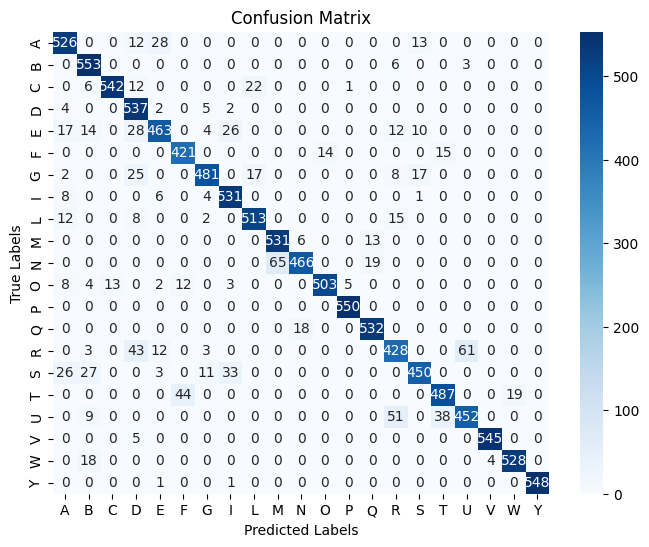

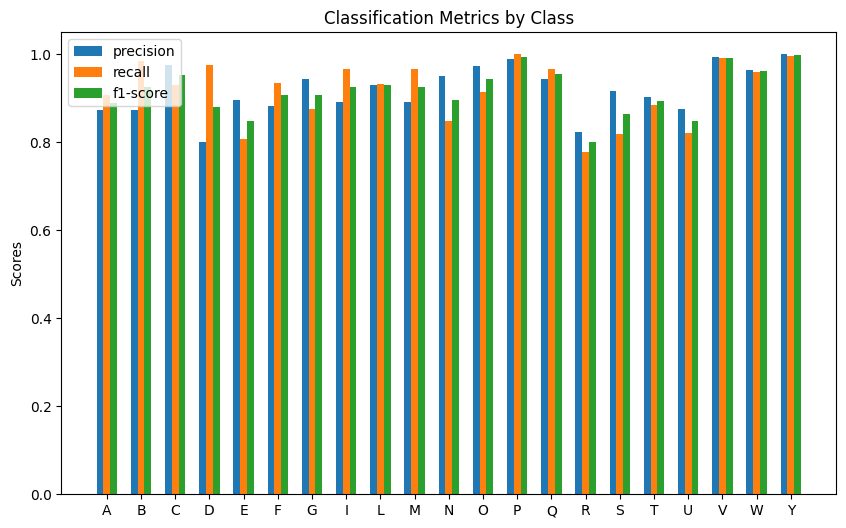

c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: Undefined

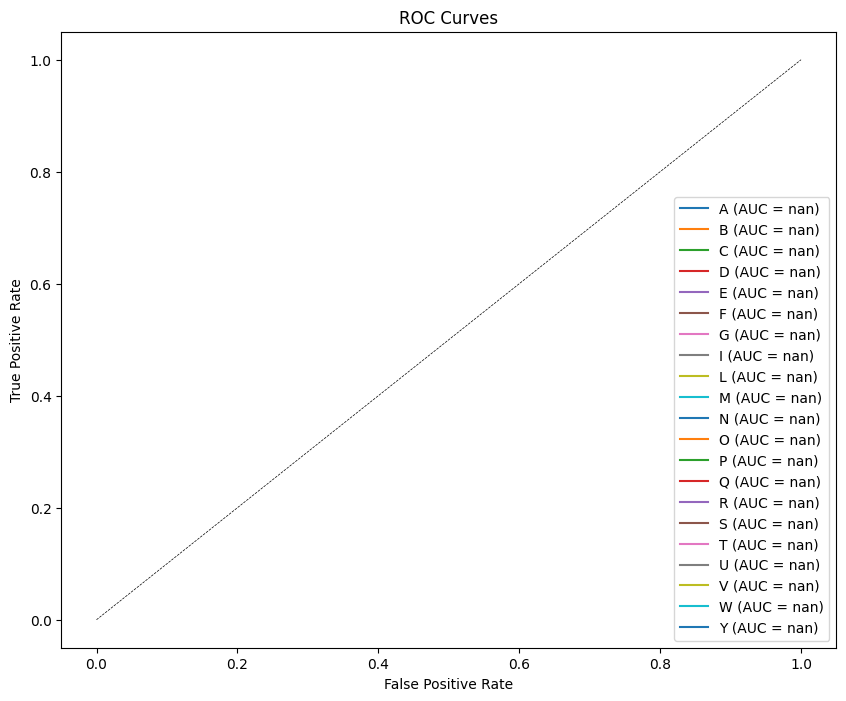

In [59]:
# Código para gerar gráficos de métricas do modelo.
letras = ["A", "B", "C", "D", "E", "F", "G", "I", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "Y"]
y_prob_teste = knn_otimizado.predict_proba(x_teste_pca)

# Código de exemplo (ajustar conforme as variáveis do notebook)
plotar_matriz_confusao(y_teste, predicao_teste_otimizado, letras)
plotar_relatorio_classificacao(y_teste, predicao_teste_otimizado, letras)
plotar_curvas_roc(y_teste, y_prob_teste, letras)

In [ ]:
x_validacao_ruidosa = x_validacao_pca + np.random.normal(0, 0.1, x_validacao_pca.shape)
x_validacao_ruidosa = np.clip(x_validacao_ruidosa, 0, 1)

y_pred_ruidosa = knn_otimizado.predict(x_validacao_ruidosa)
treino_acuracia_otimizado = accuracy_score(y_validacao, y_pred_ruidosa)

print("Acurácia:", treino_acuracia_otimizado)

In [ ]:
x_teste_ruidosa = x_teste_pca + np.random.normal(0, 0.1, x_teste_pca.shape)
x_teste_ruidosa = np.clip(x_teste_ruidosa, 0, 1)

y_pred_ruidosa = knn_otimizado.predict(x_teste_ruidosa)
teste_acuracia_otimizado = accuracy_score(y_teste, y_pred_ruidosa)

print("Acurácia:", teste_acuracia_otimizado)